In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("D:\哥大\Course\\4650_Business Analytics\Project\cleaned_US_Accidents.csv",index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Delete rows

'ID','Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)','Duration', 'Duration(min)'
'Street', 'Side', 'City','County', 'State', 'Zipcode'
       
* Dependent Variable: 'Severity'
* Independent Variables: 'Temperature(F)', 'Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Precipitation(in)', 'Weather_Condition', 'Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset'

In [3]:
df = df.drop(['ID','Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)','Wind_Direction','Duration',
              'Duration(min)','Street', 'Side', 'City','County', 'Zipcode'], axis=1)

In [4]:
#Transform the 'State' into dummy variables
df1 = pd.get_dummies(pd.DataFrame(df['State']), drop_first=True)
df = df.drop(['State','Weather_Condition'], axis=1)
df = pd.concat([df, df1], axis = 1)

## Transform the str features into numbers

In [5]:
#Night is 1, Day is 0
df['Sunrise_Sunset'] = df['Sunrise_Sunset'].apply(lambda x: 0 if x == "Day" else 1)

In [6]:
for i in range(7,18):
    df[df.columns[i]] = df[df.columns[i]].apply(lambda x: 0 if x == False else 1)
#df.head()

# Deicision Tree
## Grid Search

In [12]:
data = df.sample(frac=1)   #shuffle the dataset

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
num_folds = 5  #5折交叉验证
scoring = 'recall_weighted'  
seed = 123  #随机数种子

from sklearn.tree import DecisionTreeClassifier
param_grid = {
     'max_depth': [3,5,8,10,15],  #3,5,8,10,15
     'min_samples_split': [2,4,8], #2,4,8
     'min_samples_leaf': [1,2,4]  #4,8,16
}

model = DecisionTreeClassifier()
kfold = KFold(n_splits = num_folds, shuffle=True, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(data.iloc[0:,1:data.shape[1]], data['Severity'])
print('最优：%s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))

最优：0.9365566315364638 使用 {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


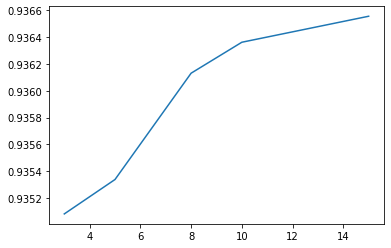

In [22]:
scores = grid.cv_results_

scores_grid_DT = []
for i in range(5):
    scores_grid_DT.append(max(scores['mean_test_score'][i:9*(i+1)]))

plt.plot(np.unique(scores['param_max_depth'].data), scores_grid_DT)
plt.show()

## Fit the Model

In [7]:
#Decision Tree Classifier
from sklearn.model_selection import train_test_split
data = df.sample(frac=1)   #shuffle the dataset
train, test = train_test_split(data, test_size = 0.3)
x_train = train.iloc[0:,1:data.shape[1]]
y_train = train[['Severity']]
x_test = test.iloc[0:,1:data.shape[1]]
y_test = test[['Severity']]

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model = DecisionTreeClassifier()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test, y_pred, average="weighted"))
print(recall_score(y_test,y_pred, average="weighted"))
print(f1_score(y_test,y_pred, average="weighted"))
print(accuracy_score(y_test,y_pred))

0.9129220749068987
0.9133076656971902
0.9130790640886913
0.9133076656971902


In [ ]:
#plot the decision tree
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin' 

import pydotplus 
feature_names = [key for key in data if not key=='Severity']
from IPython.display import Image
dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names)
import pydotplus

graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())

# Random Forest
## Grid Search

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
num_folds = 5  #10折交叉验证
scoring = 'recall_weighted'  
seed = 123  #随机数种子

In [14]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
     'n_estimators':(10, 30, 50, 80), #the number of trees  #10, 30, 50, 80
     'min_samples_split': [4],
     'min_samples_leaf': [4]
}

#param_grid = {}
#param_grid['n_estimators'] = [20,30,50,80,100,200]
model = RandomForestClassifier()
kfold = KFold(n_splits = num_folds, shuffle=True, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = scoring, cv = kfold)
grid_result = grid.fit(data.iloc[0:,1:data.shape[1]], data['Severity'])
print('最优：%s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))

最优：0.9350888024580731 使用 {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 30}


In [17]:
scores = grid.cv_results_
scores['param_n_estimators'].data

array([10, 30, 50, 80], dtype=object)

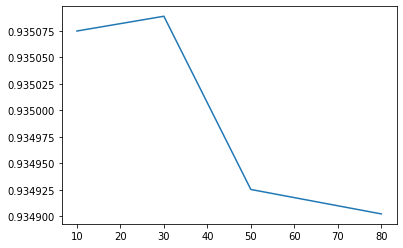

In [18]:
#params_name = [str(i) for i in scores['params']]
plt.plot(scores['param_n_estimators'].data, scores['mean_test_score'])
plt.show()

## Fit the Model

In [10]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
data = df.sample(frac=1)   #shuffle the dataset
train, test = train_test_split(data, test_size = 0.3)
x_train = train.iloc[0:,1:data.shape[1]]
y_train = train[['Severity']]
x_test = test.iloc[0:,1:data.shape[1]]
y_test = test[['Severity']]

model = RandomForestClassifier(n_estimators=30)
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test, y_pred, average="weighted"))
print(recall_score(y_test,y_pred, average="weighted"))
print(f1_score(y_test,y_pred, average="weighted"))
print(accuracy_score(y_test,y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


0.9259710336545846
0.9404012223090622
0.9286189882275202
0.9404012223090622


In [11]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.33      0.44      6328
           2       0.95      0.99      0.97    583586
           3       0.62      0.26      0.37     17303
           4       0.48      0.20      0.28     17175

    accuracy                           0.94    624392
   macro avg       0.68      0.44      0.51    624392
weighted avg       0.93      0.94      0.93    624392

[[  2075   4049    142     62]
 [   897 577212   2157   3320]
 [    94  12368   4504    337]
 [    73  13279    435   3388]]


### Feature Importance

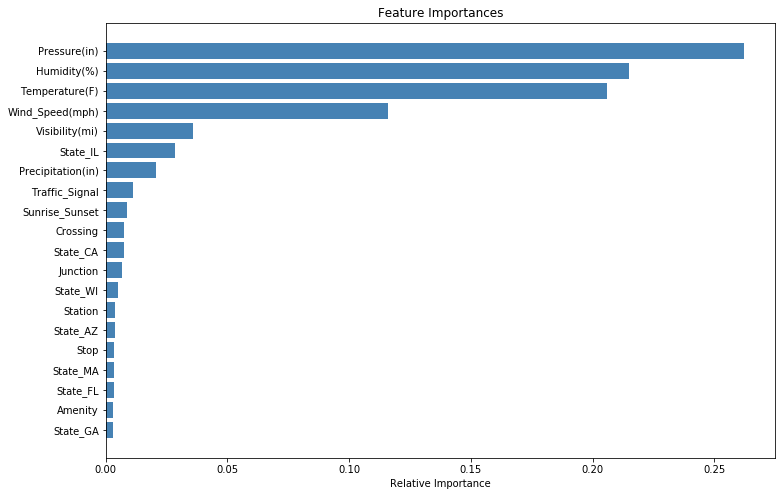

In [27]:
import pydotplus 
feature_names = [key for key in data if not key=='Severity']

import matplotlib.pyplot as plt
%matplotlib inline
importances = model.feature_importances_
indices = np.argsort(importances)
indices_top20 = indices[(len(indices)-20) : len(indices)]
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices_top20)), importances[indices_top20], color='steelblue', align='center')
# plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices_top20)),np.array(feature_names)[indices_top20])
plt.xlabel('Relative Importance')

plt.savefig('feature_importance.png', format='png', bbox_inches='tight', transparent=True, dpi=600)

## Resampling

### Undersampling

In [49]:
#doing the resampling
data_shuffled = train.sample(frac=1)

data1_major = data_shuffled[data_shuffled.Severity == 2].sample(n = 300000)
data1_minor = data_shuffled[data_shuffled.Severity != 2]
print(len(data1_major))
print(len(data1_minor))

train_new = pd.concat([data1_major, data1_minor], axis = 0)

300000
95914


In [50]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

x_train1 = train_new.iloc[0:,1:train_new.shape[1]]
y_train1 = train_new[['Severity']]

model1 = RandomForestClassifier(n_estimators=30)#we try different parameters 50,100,150,200,300,400,500
model1.fit(x_train1,y_train1)

y_pred1 = model1.predict(x_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test, y_pred1, average="weighted"))
print(recall_score(y_test,y_pred1, average="weighted"))
print(f1_score(y_test,y_pred1, average="weighted"))
print(accuracy_score(y_test,y_pred1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9179783364301823
0.9116932952376071
0.9147017155317322
0.9116932952376071


In [51]:
print(classification_report(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))

              precision    recall  f1-score   support

           1       0.42      0.43      0.42      6328
           2       0.96      0.95      0.95    583586
           3       0.34      0.40      0.37     17303
           4       0.26      0.30      0.28     17175

    accuracy                           0.91    624392
   macro avg       0.49      0.52      0.51    624392
weighted avg       0.92      0.91      0.91    624392

[[  2723   3146    307    152]
 [  3447 554393  11937  13809]
 [   212   9244   6980    867]
 [   162  10797   1058   5158]]


### SMOTE

In [54]:
from sklearn.ensemble import RandomForestClassifier

train2 = train.sample(frac=1)
x_train2 = train2.iloc[0:,1:train2.shape[1]]
y_train2 = train2[['Severity']]

from imblearn.over_sampling import SMOTE
#num_1 = int(y_train2.value_counts()[1])
num_2 = int(y_train2.value_counts()[2])
smo = SMOTE(sampling_strategy={1:60000, 2:num_2, 3:200000, 4:200000}, random_state=42)
x_train_smo, y_train_smo = smo.fit_resample(x_train2, y_train2)

model_smo = RandomForestClassifier(n_estimators=30)
model_smo.fit(x_train_smo, y_train_smo)

y_pred_smo = model_smo.predict(x_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test, y_pred_smo, average="weighted"))
print(recall_score(y_test,y_pred_smo, average="weighted"))
print(f1_score(y_test,y_pred_smo, average="weighted"))
print(accuracy_score(y_test,y_pred_smo))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9214324172410965
0.9347893630924163
0.9262108027302078
0.9347893630924163


In [55]:
print(classification_report(y_test, y_pred_smo))
print(confusion_matrix(y_test, y_pred_smo))

              precision    recall  f1-score   support

           1       0.60      0.35      0.44      6328
           2       0.95      0.98      0.97    583586
           3       0.51      0.30      0.38     17303
           4       0.38      0.22      0.28     17175

    accuracy                           0.93    624392
   macro avg       0.61      0.46      0.52    624392
weighted avg       0.92      0.93      0.93    624392

[[  2229   3855    170     74]
 [  1271 572554   4272   5489]
 [   126  11586   5156    435]
 [    92  12775    572   3736]]


### Undersampling + SMOTE

In [121]:
y_train1.value_counts()

Severity
2           300000
3            40846
4            40569
1            14499
dtype: int64

In [122]:
from imblearn.over_sampling import SMOTE
#num_1 = int(y_train2.value_counts()[1])
num_2 = int(y_train1.value_counts()[2])
smo1 = SMOTE(sampling_strategy={1:40000, 2:num_2, 3:150000, 4:150000}, random_state=42)
x_train_smo1, y_train_smo1 = smo1.fit_resample(x_train1, y_train1)

model_smo1 = RandomForestClassifier(n_estimators=30)
model_smo1.fit(x_train_smo1, y_train_smo1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9214324172410965
0.9347893630924163
0.9262108027302078
0.9347893630924163


In [124]:
y_pred_smo1 = model_smo1.predict(x_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test, y_pred_smo1, average="weighted"))
print(recall_score(y_test,y_pred_smo1, average="weighted"))
print(f1_score(y_test,y_pred_smo1, average="weighted"))
print(accuracy_score(y_test,y_pred_smo1))

print(classification_report(y_test, y_pred_smo1))
print(confusion_matrix(y_test, y_pred_smo1))

0.9164073441064163
0.8865472331484068
0.8998158058513639
0.8865472331484068
              precision    recall  f1-score   support

           1       0.35      0.45      0.39      6328
           2       0.96      0.92      0.94    583586
           3       0.27      0.45      0.34     17303
           4       0.20      0.34      0.25     17175

    accuracy                           0.89    624392
   macro avg       0.45      0.54      0.48    624392
weighted avg       0.92      0.89      0.90    624392

[[  2857   2854    411    206]
 [  4838 537054  19167  22527]
 [   264   8065   7838   1136]
 [   213   9795   1363   5804]]


## PCA

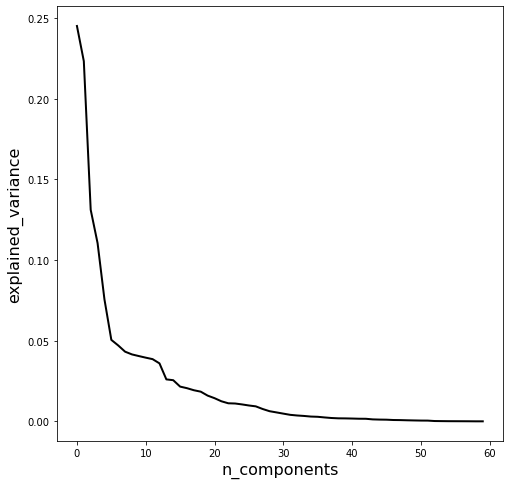

In [63]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(df.iloc[:,7:df.shape[1]])

fig = plt.figure(figsize = (8,8))
plt.plot(pca.explained_variance_, 'k', linewidth = 2)
plt.xlabel('n_components', fontsize=16)
plt.ylabel('explained_variance', fontsize=16)
plt.show()

In [87]:
from sklearn.decomposition import PCA
pca=PCA(n_components=10)
pca.fit(df.iloc[:,7:df.shape[1]])

PCA(n_components=10)

In [88]:
pca_df = pd.DataFrame(pca.transform(df.iloc[:,7:df.shape[1]]))
df_pca_1 = df.iloc[:, 0:7].reset_index(drop = True)
pca_df = pd.concat([df_pca_1, pca_df], axis = 1)

In [89]:
from sklearn.model_selection import train_test_split
train_pca, test_pca = train_test_split(pca_df.sample(frac=1), test_size = 0.3)
x_train_pca = train_pca.iloc[0:,1:pca_df.shape[1]]
y_train_pca = train_pca[['Severity']]
x_test_pca = test_pca.iloc[0:,1:pca_df.shape[1]]
y_test_pca = test_pca[['Severity']]

model_pca = RandomForestClassifier(n_estimators=30)
model_pca.fit(x_train_pca,y_train_pca)

y_pred_pca = model_pca.predict(x_test_pca)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test_pca, y_pred_pca, average="weighted"))
print(recall_score(y_test_pca, y_pred_pca, average="weighted"))
print(f1_score(y_test_pca, y_pred_pca, average="weighted"))
print(accuracy_score(y_test_pca, y_pred_pca))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.9258899997725492
0.9401145434278466
0.9288186808515643
0.9401145434278466


In [116]:
print(classification_report(y_test_pca, y_pred_pca))
print(confusion_matrix(y_test_pca, y_pred_pca))

              precision    recall  f1-score   support

           1       0.65      0.35      0.46      6266
           2       0.95      0.99      0.97    583364
           3       0.61      0.27      0.37     17472
           4       0.48      0.21      0.29     17290

    accuracy                           0.94    624392
   macro avg       0.67      0.45      0.52    624392
weighted avg       0.93      0.94      0.93    624392

[[  2213   3841    147     65]
 [  1002 576572   2387   3403]
 [   119  12348   4668    337]
 [    74  13210    459   3547]]


# Combine 1 and 2, 3 and 4

In [91]:
df_new = df.copy()

In [92]:
df_new['Severity'] = df_new['Severity'].apply(lambda x: 0 if int(x) == 1 else x)
df_new['Severity'] = df_new['Severity'].apply(lambda x: 0 if int(x) == 2 else x)
df_new['Severity'] = df_new['Severity'].apply(lambda x: 1 if int(x) == 3 else x)
df_new['Severity'] = df_new['Severity'].apply(lambda x: 1 if int(x) == 4 else x)

In [93]:
df_new['Severity'].value_counts()

0    1965412
1     115893
Name: Severity, dtype: int64

In [119]:
y_train_01.value_counts()

Severity
0           1375749
1             81164
dtype: int64

In [94]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
data_01 = df_new.sample(frac=1)   #shuffle the dataset
train_01, test_01 = train_test_split(data_01, test_size = 0.3)
x_train_01 = train_01.iloc[0:,1:data.shape[1]]
y_train_01 = train_01[['Severity']]
x_test_01 = test_01.iloc[0:,1:data.shape[1]]
y_test_01 = test_01[['Severity']]

model_01 = RandomForestClassifier(n_estimators=30) 
model_01.fit(x_train_01,y_train_01)

y_pred_01 = model_01.predict(x_test_01)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test_01, y_pred_01))
print(recall_score(y_test_01, y_pred_01))
print(f1_score(y_test_01, y_pred_01))
print(accuracy_score(y_test_01, y_pred_01))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


0.6151880487485257
0.27035042759653316
0.37562761297033465
0.950010570282771


In [95]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_01, y_pred_01))
print(confusion_matrix(y_test_01, y_pred_01))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    589663
           1       0.62      0.27      0.38     34729

    accuracy                           0.95    624392
   macro avg       0.79      0.63      0.67    624392
weighted avg       0.94      0.95      0.94    624392

[[583790   5873]
 [ 25340   9389]]


## Undersampling

In [96]:
#doing the resampling
data_shuffled_01 = train_01.sample(frac=1)

data1_major_01 = data_shuffled_01[data_shuffled_01.Severity == 0].sample(n = 300000)
data1_minor_01 = data_shuffled_01[data_shuffled_01.Severity == 1]
#data1_minor = pd.concat([data1_minor, data1_minor], axis=0)
print(len(data1_major_01))
print(len(data1_minor_01))

train_new_01 = pd.concat([data1_major_01, data1_minor_01], axis = 0)

300000
81164


In [97]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train1_01 = train_new_01.iloc[0:,1:train_new_01.shape[1]]
y_train1_01 = train_new_01[['Severity']]

model1_01 = RandomForestClassifier(n_estimators=30)#we try different parameters 50,100,150,200,300,400,500
model1_01.fit(x_train1_01,y_train1_01)

y_pred1_01 = model1_01.predict(x_test_01)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test_01, y_pred1_01))
print(recall_score(y_test_01, y_pred1_01))
print(f1_score(y_test_01, y_pred1_01))
print(accuracy_score(y_test_01, y_pred1_01))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


0.3229354453199376
0.4590687897722365
0.37915289305334254
0.9163794539327859


In [98]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_01, y_pred1_01))
print(confusion_matrix(y_test_01, y_pred1_01))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    589663
           1       0.32      0.46      0.38     34729

    accuracy                           0.92    624392
   macro avg       0.65      0.70      0.67    624392
weighted avg       0.93      0.92      0.92    624392

[[556237  33426]
 [ 18786  15943]]


## Oversampling

In [99]:
x_train_01 = train_01.iloc[0:,1:data.shape[1]]
y_train_01 = train_01[['Severity']]

from imblearn.over_sampling import SMOTE
num_0 = int(y_train_01.value_counts()[0])
smo_01 = SMOTE(sampling_strategy={0:num_0, 1:300000}, random_state=42)
x_train_smo_01, y_train_smo_01 = smo_01.fit_resample(x_train_01, y_train_01)

model_smo_01 = RandomForestClassifier(n_estimators=30)
model_smo_01.fit(x_train_smo_01, y_train_smo_01)

y_pred_smo_01 = model_smo_01.predict(x_test_01)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test_01, y_pred_smo_01))
print(recall_score(y_test_01, y_pred_smo_01))
print(f1_score(y_test_01, y_pred_smo_01))
print(accuracy_score(y_test_01, y_pred_smo_01))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.5053717232488182
0.30475971090443144
0.3802270441155338
0.9447398429191918


In [101]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_01, y_pred_smo_01))
print(confusion_matrix(y_test_01, y_pred_smo_01))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    589663
           1       0.51      0.30      0.38     34729

    accuracy                           0.94    624392
   macro avg       0.73      0.64      0.68    624392
weighted avg       0.93      0.94      0.94    624392

[[579304  10359]
 [ 24145  10584]]


## Undersampling + Oversampling

In [103]:
train_new_01['Severity'].value_counts()

0    300000
1     81164
Name: Severity, dtype: int64

In [104]:
x_train1_01 = train_new_01.iloc[0:,1:train_new_01.shape[1]]
y_train1_01 = train_new_01[['Severity']]

from imblearn.over_sampling import SMOTE
num_0 = int(y_train1_01.value_counts()[0])
smo_02 = SMOTE(sampling_strategy={0:num_0, 1:200000}, random_state=42)
x_train_smo_02, y_train_smo_02 = smo_02.fit_resample(x_train1_01, y_train1_01)

model_smo_02 = RandomForestClassifier(n_estimators=30)
model_smo_02.fit(x_train_smo_02, y_train_smo_02)

y_pred_smo_02 = model_smo_02.predict(x_test_01)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test_01, y_pred_smo_02))
print(recall_score(y_test_01, y_pred_smo_02))
print(f1_score(y_test_01, y_pred_smo_02))
print(accuracy_score(y_test_01, y_pred_smo_02))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.26758624861987085
0.5094301592329178
0.3508716260436706
0.8951588104908454


In [107]:
print(classification_report(y_test_01, y_pred_smo_02))
print(confusion_matrix(y_test_01, y_pred_smo_02))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94    589663
           1       0.27      0.51      0.35     34729

    accuracy                           0.90    624392
   macro avg       0.62      0.71      0.65    624392
weighted avg       0.93      0.90      0.91    624392

[[541238  48425]
 [ 17037  17692]]


## PCA

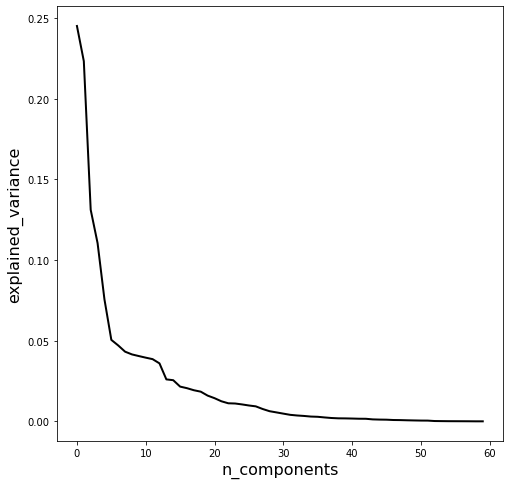

In [110]:
from sklearn import decomposition
pca_01 = decomposition.PCA()
pca_01.fit(df_new.iloc[:,7:df_new.shape[1]])

fig = plt.figure(figsize = (8,8))
plt.plot(pca_01.explained_variance_, 'k', linewidth = 2)
plt.xlabel('n_components', fontsize=16)
plt.ylabel('explained_variance', fontsize=16)
plt.show()

In [111]:
from sklearn.decomposition import PCA
pca_01=PCA(n_components=10)
pca_01.fit(df_new.iloc[:,7:df_new.shape[1]])

PCA(n_components=10)

In [112]:
pca_df_01 = pd.DataFrame(pca_01.transform(df_new.iloc[:,7:df_new.shape[1]]))
df_pca_1_01 = df_new.iloc[:, 0:7].reset_index(drop = True)
pca_df_01 = pd.concat([df_pca_1_01, pca_df_01], axis = 1)

In [117]:
from sklearn.model_selection import train_test_split
train_pca_01, test_pca_01 = train_test_split(pca_df_01.sample(frac=1), test_size = 0.3)
x_train_pca_01 = train_pca_01.iloc[0:,1:pca_df.shape[1]]
y_train_pca_01 = train_pca_01[['Severity']]
x_test_pca_01 = test_pca_01.iloc[0:,1:pca_df.shape[1]]
y_test_pca_01 = test_pca_01[['Severity']]

model_pca_01 = RandomForestClassifier(n_estimators=30)
model_pca_01.fit(x_train_pca_01,y_train_pca_01)

y_pred_pca_01 = model_pca_01.predict(x_test_pca_01)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test_pca_01, y_pred_pca_01))
print(recall_score(y_test_pca_01, y_pred_pca_01))
print(f1_score(y_test_pca_01, y_pred_pca_01))
print(accuracy_score(y_test_pca_01, y_pred_pca_01))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.5872874904846486
0.26586640629487107
0.3660301269125846
0.9486380350805264


In [118]:
print(classification_report(y_test_pca_01, y_pred_pca_01))
print(confusion_matrix(y_test_pca_01, y_pred_pca_01))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    589570
           1       0.59      0.27      0.37     34822

    accuracy                           0.95    624392
   macro avg       0.77      0.63      0.67    624392
weighted avg       0.94      0.95      0.94    624392

[[583064   6506]
 [ 25564   9258]]
